* In this notebook, we will explore the effect of feature number on the R2, RMSE and MAE errors

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
ERed_data=pd.read_csv(r"../Data/Reduction_potential_213BzNSN.csv")
# ERed_data=pd.read_csv(r"../Data/All_bzNSN_derivates_from_AL_and_DFT.csv",usecols=["SMILES","Ered(V)"])
ERed_data.head()

,SMILES,Ered(V)
0,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,1.27
1,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,1.27
2,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,1.24
3,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,1.22
4,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,1.20


In [3]:
print(f"Before: ERed_data.shape={ERed_data.shape}")
ERed_data=ERed_data.loc[ERed_data["SMILES"].drop_duplicates().index,:]
print(f"After: ERed_data.shape={ERed_data.shape}")

Before: ERed_data.shape=(1569, 2)
After: ERed_data.shape=(1530, 2)


# No duplicate SMILES found
- check again with mol descriptors
- SMILES string is not a unique representation of a molecule

In [4]:
isnd=np.arange(0,ERed_data.shape[0],1)
ERed_data.index=isnd
print(ERed_data.shape)
ERed_data.head()

(1530, 2)


,SMILES,Ered(V)
0,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,1.27
1,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,1.27
2,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,1.24
3,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,1.22
4,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,1.20


* Feature Generation and Exploration

In [5]:
# 2D Mol. Descriptors
from rdkit.Chem import Descriptors
desc_list = [desc[0] for desc in Descriptors._descList]
# print(len(desc_list))
# print(desc_list)

In [6]:
from rdkit.Chem import rdMolDescriptors 
import rdkit.Chem as Chem

def smi_to_mol_prop(smi,property_names = list(rdMolDescriptors.Properties.GetAvailableProperties())):
    """
    This function will return a numpy array with all molecular properties of a SMILES string
    Input (smi): a SMILES string
    Output: np.array()
    eg. df['mol_prop'] = df.SMILES.apply(smi2molprop)
    output: each row of df['mol_prop'] will have a np.array with all molecular props.
    """
    property_getter = rdMolDescriptors.Properties(property_names)
    
    mol = Chem.MolFromSmiles(smi)
    props = None
    if mol:
        props = np.array(property_getter.ComputeProperties(mol))
    return props

In [7]:
properties=list(rdMolDescriptors.Properties.GetAvailableProperties())

In [8]:
#Generate descriptors for each molecule
from rdkit.ML.Descriptors import MoleculeDescriptors

calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_list)

rdkit_desc = [calc.CalcDescriptors(Chem.MolFromSmiles(x)) for x in ERed_data["SMILES"]]

In [9]:
df_2Ddescp = pd.DataFrame(rdkit_desc,columns=desc_list)
print(df_2Ddescp.shape)
# df_2Ddescp.head()

(1530, 208)


# Remove duplicate molecules
- SMILES string is not unique for a molecule, pandas might have missed some duplicate molecules at the start

In [10]:
print(f"Before: ERed_data.shape={ERed_data.shape}")
without_duplicate_mols=df_2Ddescp.drop_duplicates().index
ERed_data=ERed_data.loc[without_duplicate_mols,:]
ERed_data.index=np.arange(ERed_data.shape[0])
print(f"After: ERed_data.shape={ERed_data.shape}")

print(f"Before: df_2Ddescp.shape={df_2Ddescp.shape}")
df_2Ddescp=df_2Ddescp.loc[without_duplicate_mols,:]
df_2Ddescp.index=np.arange(df_2Ddescp.shape[0])
print(f"After: df_2Ddescp.shape={df_2Ddescp.shape}")

Before: ERed_data.shape=(1530, 2)
After: ERed_data.shape=(1530, 2)
Before: df_2Ddescp.shape=(1530, 208)
After: df_2Ddescp.shape=(1530, 208)


In [11]:
# 3D Descriptors
import rdkit.Chem.Descriptors3D as Rdkit3d

desc_3d=[]
for m in dir(Rdkit3d):
    if "__" not in m:
        desc_3d.append(str(m))
print(desc_3d)
desc_3d.remove('rdMolDescriptors')
print(desc_3d)

['Asphericity', 'Eccentricity', 'InertialShapeFactor', 'NPR1', 'NPR2', 'PMI1', 'PMI2', 'PMI3', 'RadiusOfGyration', 'SpherocityIndex', 'rdMolDescriptors']
['Asphericity', 'Eccentricity', 'InertialShapeFactor', 'NPR1', 'NPR2', 'PMI1', 'PMI2', 'PMI3', 'RadiusOfGyration', 'SpherocityIndex']


In [12]:
from rdkit.Chem.Descriptors3D import *
from rdkit.Chem import AllChem
def rdkit_all_3D(smi):
    # print(smi)
    m=Chem.MolFromSmiles(smi)
    m=Chem.AddHs(m)
    AllChem.EmbedMolecule(m)
    AllChem.UFFOptimizeMolecule(m)
    asp=Asphericity(m)
    ecc=Eccentricity(m)
    isf=InertialShapeFactor(m)
    npr1=NPR1(m)
    npr2=NPR2(m)
    pmi1=PMI1(m)
    pmi2=PMI2(m)
    pmi3=PMI3(m)
    RadG=RadiusOfGyration(m)
    Si=SpherocityIndex(m)
    return [asp,ecc,isf,npr1,npr2,pmi1,pmi2,pmi3,RadG,Si]

In [13]:
df_molprop=pd.DataFrame(ERed_data["SMILES"].apply(lambda x:smi_to_mol_prop(x,property_names=properties)).to_list(),columns=properties)

In [14]:
#add 3D descriptors
new_3d=ERed_data["SMILES"].apply(lambda x:rdkit_all_3D(x))
df_3Ddesc=pd.DataFrame(new_3d.to_list(),columns=desc_3d)

In [15]:

Xdata_btz=pd.concat([df_molprop,df_2Ddescp,df_3Ddesc],axis=1)
print(Xdata_btz.shape)
Xdata_btz.head()

(1530, 261)


,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,...,Asphericity,Eccentricity,InertialShapeFactor,NPR1,NPR2,PMI1,PMI2,PMI3,RadiusOfGyration,SpherocityIndex
0,291.151767,291.424,5.0,0.0,3.0,0.0,6.0,20.0,41.0,6.0,...,0.380879,0.958980,0.000797,0.283475,0.769909,965.648451,2622.668901,3406.464761,3.464252,0.200792
1,292.135782,292.408,5.0,0.0,4.0,0.0,6.0,20.0,40.0,6.0,...,0.274450,0.923664,0.000491,0.383203,0.659686,1344.063022,2313.808908,3507.441253,3.500322,0.138349
2,291.151767,291.424,5.0,1.0,3.0,1.0,6.0,20.0,41.0,6.0,...,0.164608,0.875604,0.000600,0.483029,0.725397,1209.358252,1816.171936,2503.695064,3.080027,0.500454
3,305.167417,305.451,5.0,1.0,5.0,1.0,6.0,21.0,44.0,6.0,...,0.231434,0.880471,0.000343,0.474100,0.558953,1630.344962,1922.142395,3438.824291,3.382934,0.130196
4,305.167417,305.451,5.0,1.0,4.0,1.0,6.0,21.0,44.0,6.0,...,0.197662,0.875232,0.000409,0.483704,0.611467,1496.452447,1891.716716,3093.735698,3.257358,0.250279


In [16]:
# Remove columns with all 0
print(f"Initial Xdata_btz shape = %d x %d" %Xdata_btz.shape)
Xdata_btz=Xdata_btz.drop(Xdata_btz.columns[Xdata_btz.eq(0).all()],axis=1)
print(f"Xdata_btz shape (now) = %d x %d" %Xdata_btz.shape)

Initial Xdata_btz shape = 1530 x 261
Xdata_btz shape (now) = 1530 x 174


In [17]:
# Remove duplicates
print(f"Initial Xdata_btz shape = %d x %d" %Xdata_btz.shape)
Xdata_btz=Xdata_btz.loc[:,~Xdata_btz.columns.duplicated()].copy()
print(f"Xdata_btz shape (now) = %d x %d" %Xdata_btz.shape)

Initial Xdata_btz shape = 1530 x 174
Xdata_btz shape (now) = 1530 x 166


In [18]:
all_desc=Xdata_btz.columns
print(len(all_desc))

166


# add more ringstats

In [19]:
def ring_stats(smiles):
    """
    if smi="CN1CN(C)c2cc3nsnc3cc21" 
    then ring_stats(smi) will return a list of number of rings of size [1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    # rings start with size 3
    Output:    [0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0]
    molecule has 2 and 1 rings of size 5 and 6, respectively
    """
    m = Chem.MolFromSmiles(smiles)
    
    d=13 # rings won't have more than 13 atoms
    nring=[0]*d
    rings=m.GetRingInfo()
    for ring in rings.AtomRings():
        sr=""
        n=0
        for atom in ring:
            sr+=m.GetAtomWithIdx(atom).GetSymbol()
            n+=1

        if(n<d):
            nring[n]+=1 # total rings
    return nring    

In [20]:
def hetroring_stats(smiles):
    """
    Retrun a list of number of hetrocylces of sizes from 3 to 13

    Eg. if smi="CN1CN(C)c2cc3nsnc3cc21" 
    # rings start with size 3
    then the hetroring_stats(smi) will return :  hetrocycle ring of size [1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
    Output: [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]
    There are 2 hetrorings of size 5
    """
    m = Chem.MolFromSmiles(smiles)
    
    d=13 # rings won't have more than 13 atoms
    nHring=[0]*d
    
    rings=m.GetRingInfo()
    for ring in rings.AtomRings():
        sr=""
        n=0
        for atom in ring:
            sr+=m.GetAtomWithIdx(atom).GetSymbol()
            n+=1

        if(n<d):
            c=sr.count('C')
            if(c<n): # hetro-atom cycle
                nHring[n]+=1
    return nHring    

In [21]:
def other_ring_stats(smiles):
    """
    Return a list which contains [number of carbon atoms (nC) in all homocycles, nC in all heterocycles,nN in all hetrocycle, nS in all hetrocycles, nO in all hetrocycles ]
    """
    m = Chem.MolFromSmiles(smiles)
    
    numH_C,numH_N,numH_S,numH_O=0,0,0,0
    num_C_homo=0
    ri=m.GetRingInfo()
    
    for r in ri.AtomRings():
        sr=""
        ringsize=0
        for i in r:
            sr+=m.GetAtomWithIdx(i).GetSymbol()
            ringsize+=1
        # print(sr)
        num_c=sr.count('C')
        
        # count number of S, N, C, and O in hetrocycles
        if  num_c < ringsize: # count in hetrocycles
            numH_C+=num_c
            numH_N+=sr.count('N')
            numH_S+=sr.count('S')
            numH_O+=sr.count('O')
        else:
            num_C_homo+=ringsize
    return [num_C_homo,numH_C,numH_N,numH_O,numH_S]

In [22]:
new_RingD=ERed_data["SMILES"].apply(lambda smi:other_ring_stats(smi)).to_list()
col_txt=["nhomo_C","nhetro_C","nhetro_N","nhetro_O","nhetro_S"]
df_ringD=pd.DataFrame(new_RingD,columns=col_txt)
df_ringD=df_ringD.drop(df_ringD.columns[df_ringD.eq(0).all()],axis=1)

In [23]:
new_RingD=ERed_data["SMILES"].apply(lambda smi:ring_stats(smi)).to_list()
col_txt=["nring"+str(i) for i in range(len(new_RingD[0]))]

df_ring=pd.DataFrame(new_RingD,columns=col_txt)
df_ring=df_ring.drop(df_ring.columns[df_ring.eq(0).all()],axis=1)

In [24]:
new_RingD=ERed_data["SMILES"].apply(lambda smi:hetroring_stats(smi)).to_list()
col_txt=["nHring"+str(i) for i in range(len(new_RingD[0]))]

df_ringh=pd.DataFrame(new_RingD,columns=col_txt)
df_ringh=df_ringh.drop(df_ringh.columns[df_ringh.eq(0).all()],axis=1)

In [25]:
def substruct_in_smi(mol_smi_str,pat_smi_str):
    """
    This function will return True if the substructure (pattern) is present in the SMILES string.
    Input: smi_str = A SMILES string;   sub_str = Pattern 
    Output: True (substruture found in the smi); False (substruture not found in the smi)
    """   
    mol = Chem.MolFromSmiles(mol_smi_str)
    pat = Chem.MolFromSmiles(pat_smi_str) 

    return mol.HasSubstructMatch(pat)

In [26]:
newclass=ERed_data["SMILES"].apply(lambda x:1*substruct_in_smi(mol_smi_str=x,pat_smi_str="c1c2c(cc3nsnc13)N(C)CN2C"))
df_class=pd.DataFrame(newclass.to_list(),columns=["Scaffold"])

In [27]:
Xdata_btz_corr_scaffold_rings=pd.concat([Xdata_btz,df_ring,df_ringh,df_ringD,df_class],axis=1)
# Xdata_btz_uncorr_clean_scaffold_rings

In [28]:
Xdata_btz_corr_scaffold_rings.shape

(1530, 182)

# Drop columns with identical values

In [29]:
Xdata_btz_corr_scaffold_rings=Xdata_btz_corr_scaffold_rings.loc[:,Xdata_btz_corr_scaffold_rings.nunique()>1]

In [30]:
Xdata_btz_corr_scaffold_rings.shape

(1530, 173)

In [31]:
def remove_corr_features(Xdata,corr_cutoff = 0.75):
    """
    This function will drop highly correlated features
    Output: a pd.Dataframe 
    """
    cor_matrix=Xdata.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool_))

    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > corr_cutoff)]
    print(f"Dropped %d features with correlation coeff. > %0.2f" %(len(to_drop),corr_cutoff))

    Xdata=Xdata.drop(columns=to_drop,axis=1)
    print(f"Remaining features %d" %(Xdata.shape[1]))
    return Xdata

In [32]:
Xdata_btz_uncorr=remove_corr_features(Xdata=Xdata_btz_corr_scaffold_rings, corr_cutoff=0.8)
print(Xdata_btz_uncorr.shape)

Dropped 109 features with correlation coeff. > 0.80
Remaining features 64
(1530, 64)


# ERed and Feauture correlation

In [33]:
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt

In [34]:
target = 'Ered(V)'
descriptors=Xdata_btz_uncorr.columns
corr_ered_feat=[]

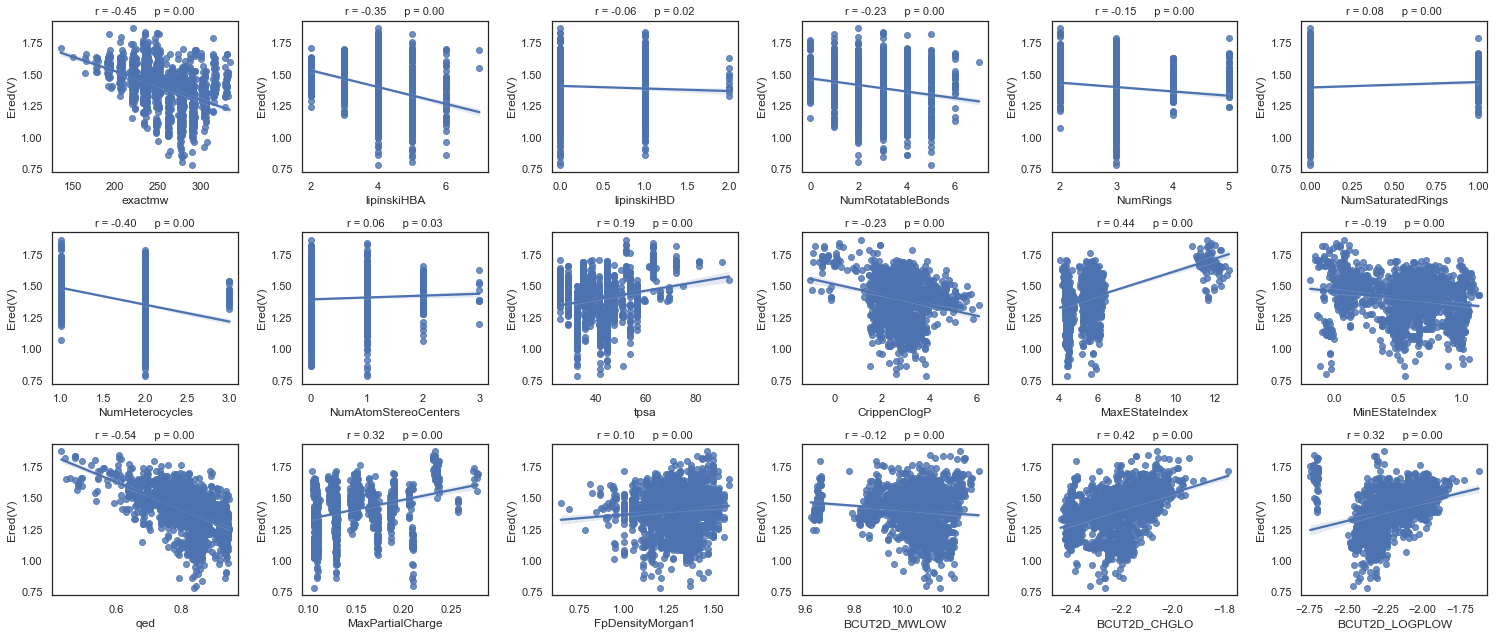

In [35]:
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(descriptors):
            
            sns.regplot(x=Xdata_btz_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(Xdata_btz_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

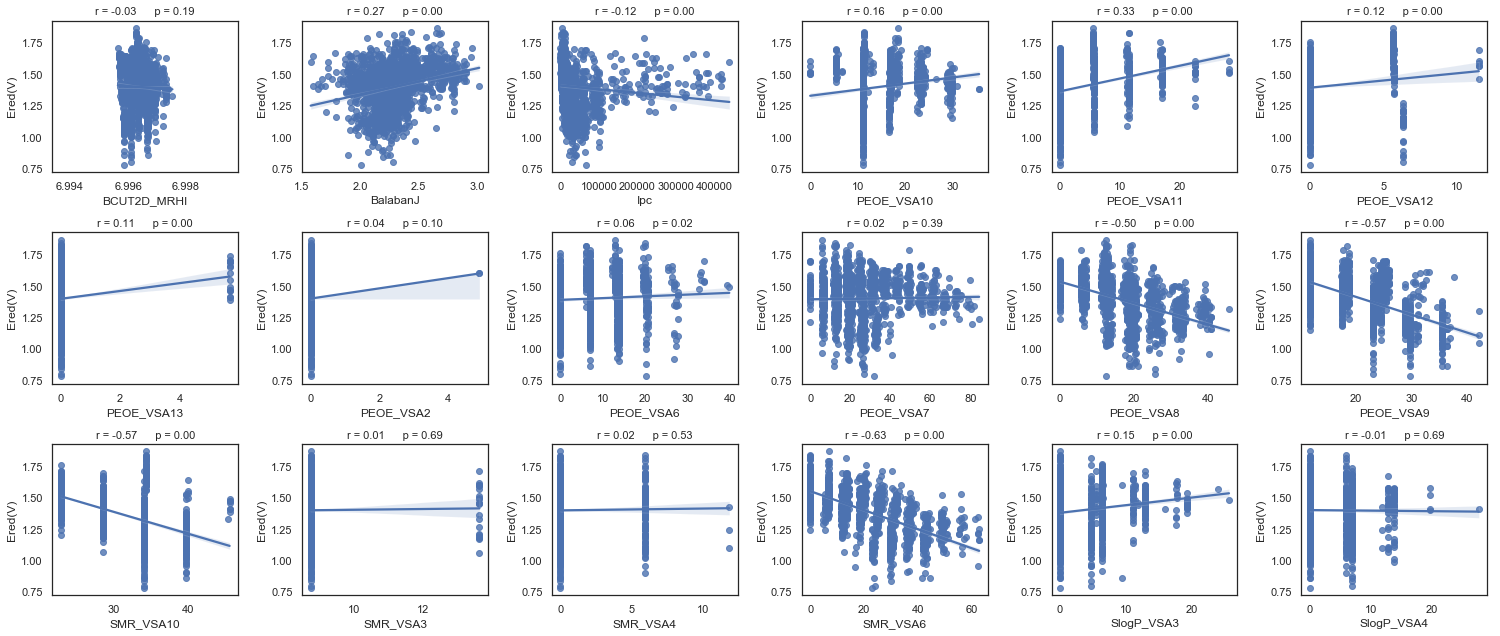

In [36]:
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18
        
        if i < len(descriptors):
            
            sns.regplot(x=Xdata_btz_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(Xdata_btz_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

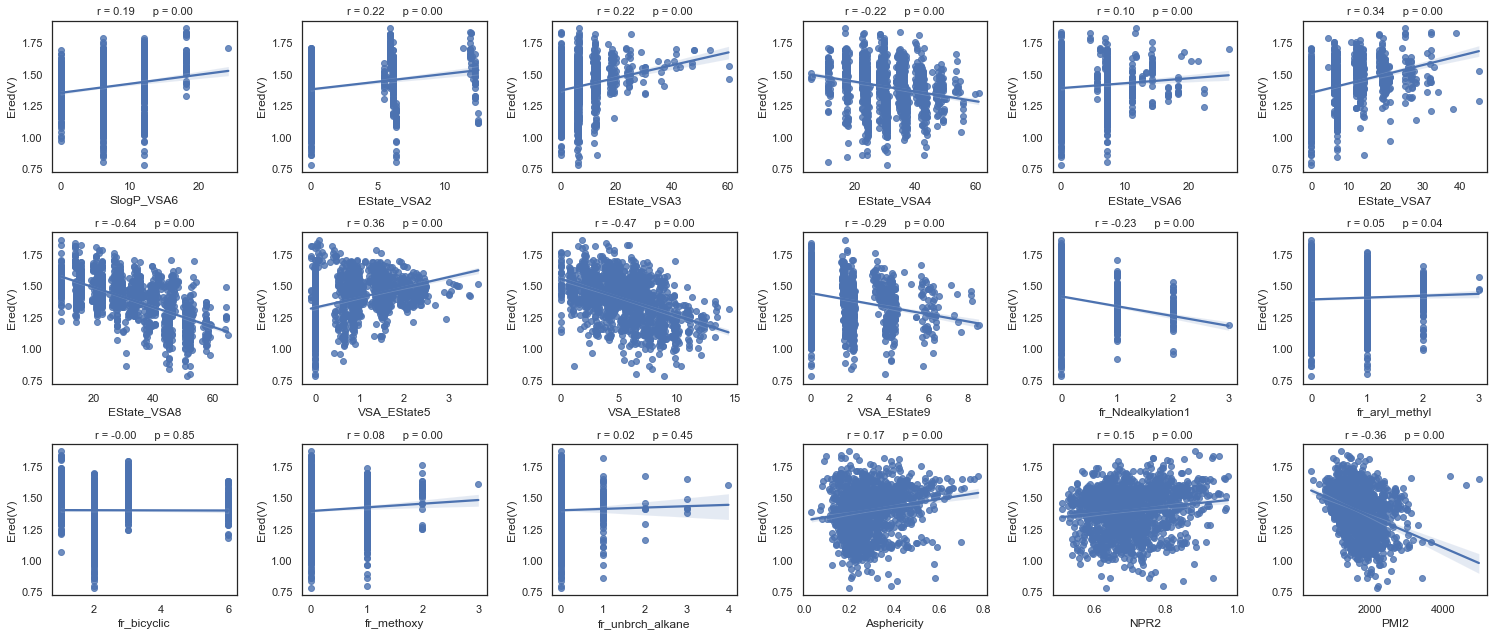

In [37]:
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18+18
        
        if i < len(descriptors):
            
            sns.regplot(x=Xdata_btz_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(Xdata_btz_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

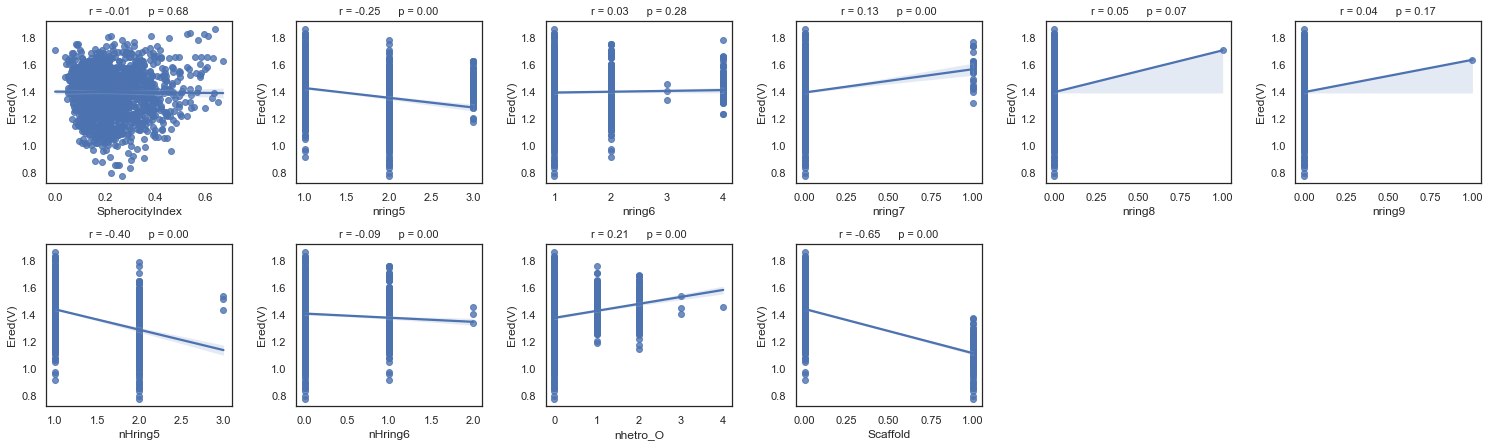

In [38]:
nr_rows = 3
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c+18+18+18
        
        if i < len(descriptors):
            
            sns.regplot(x=Xdata_btz_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            # print(f"r={r},c={c},axs[r={r}][c={c}]={axs[r][c]}")
            stp = stats.pearsonr(Xdata_btz_uncorr[descriptors[i]], ERed_data[target])
            corr_ered_feat.append([i,stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            if type(stp[0]) is not int:
                corr_ered_feat.append([descriptors[i],stp[0]])
            
            axs[r][c].set_title(str_title,fontsize=11)
        else:
            fig.delaxes(axs[r][c])

plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

In [39]:
Xdata_btz_uncorr.columns

Index(['exactmw', 'lipinskiHBA', 'lipinskiHBD', 'NumRotatableBonds',
       'NumRings', 'NumSaturatedRings', 'NumHeterocycles',
       'NumAtomStereoCenters', 'tpsa', 'CrippenClogP', 'MaxEStateIndex',
       'MinEStateIndex', 'qed', 'MaxPartialCharge', 'FpDensityMorgan1',
       'BCUT2D_MWLOW', 'BCUT2D_CHGLO', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI',
       'BalabanJ', 'Ipc', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA13', 'PEOE_VSA2', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8',
       'PEOE_VSA9', 'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA6',
       'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA6', 'EState_VSA2', 'EState_VSA3',
       'EState_VSA4', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8',
       'VSA_EState5', 'VSA_EState8', 'VSA_EState9', 'fr_Ndealkylation1',
       'fr_aryl_methyl', 'fr_bicyclic', 'fr_methoxy', 'fr_unbrch_alkane',
       'Asphericity', 'NPR2', 'PMI2', 'SpherocityIndex', 'nring5', 'nring6',
       'nring7', 'nring8', 'nring9', 'nHring5', 'nHring6', 'nhetro_O',
    

In [40]:
corr_ered_feat=pd.DataFrame(corr_ered_feat,columns=["Descriptors","Pearsons"])

remove_desc2=[i for i,desc in enumerate(corr_ered_feat["Descriptors"]) if type(desc) is int]
corr_ered_feat=corr_ered_feat.drop(remove_desc2)
corr_ered_feat_sorted=corr_ered_feat.dropna(axis=0).sort_values("Pearsons")

# Select most dominant features

In [41]:
df_reducedDescp=pd.concat([corr_ered_feat_sorted[:15],corr_ered_feat_sorted[-15:]])

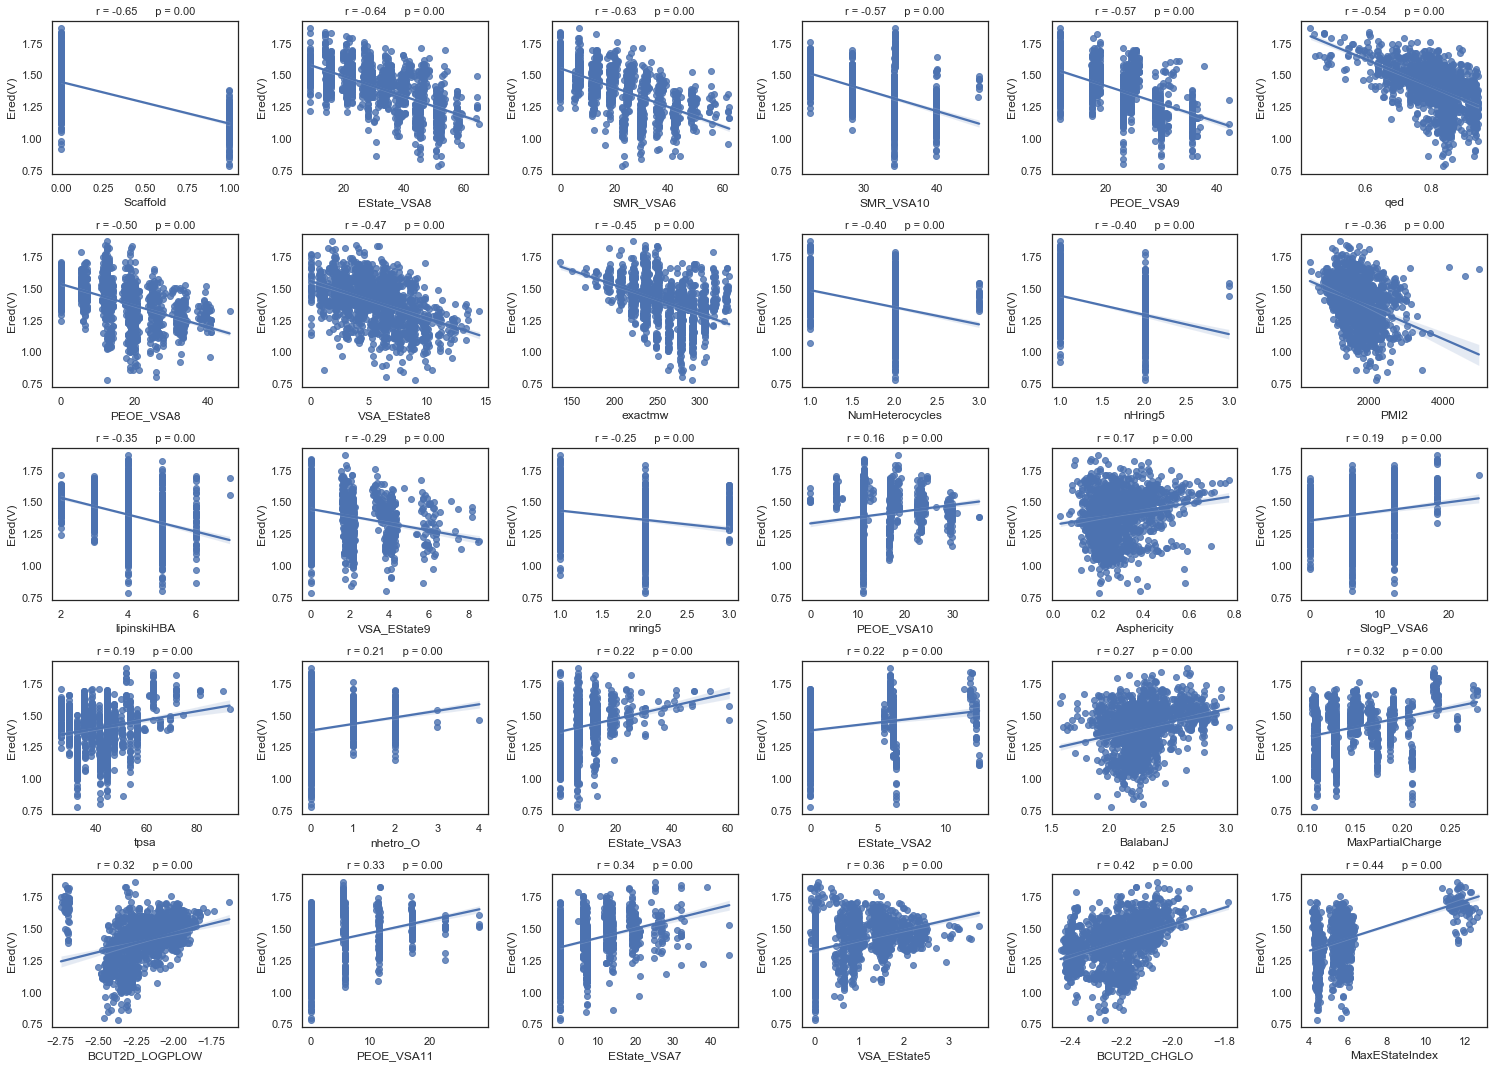

In [42]:
target = 'Ered(V)'
descriptors=df_reducedDescp.Descriptors.to_list()

nr_rows = 5
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(descriptors):

            # print(i,descriptors[i])
            sns.regplot(x=Xdata_btz_uncorr[descriptors[i]], y=ERed_data[target], ax = axs[r][c])
            
            stp = stats.pearsonr(Xdata_btz_uncorr[descriptors[i]], ERed_data[target])
            # corr_ered_feat.append([descriptors[i],stp[0]])
            # str_title = "Pearson’s correlation coefficient (r) = " + "{0:.2f}".format(stp[0]) + "      " "Two-tailed p-value (p) = " + "{0:.2f}".format(stp[1])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            corr_ered_feat.append([descriptors[i],stp[0]])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

# Remove Outliers with local outlier factor algorithm (LOC). Unsupervised Algo

In [43]:
Xdata_btz_uncorr_clean=Xdata_btz_uncorr.loc[:,df_reducedDescp["Descriptors"].to_list()]

In [44]:
X=Xdata_btz_uncorr_clean
Y=ERed_data["Ered(V)"]
print(f"X.shape={X.shape},Y.shape={Y.shape}")

X.shape=(1530, 30),Y.shape=(1530,)


# Find outliers with IQR

In [45]:
#Xdata_btz_uncorr_clean
q1_btz=ERed_data["Ered(V)"].quantile(0.25)
q3_btz=ERed_data["Ered(V)"].quantile(0.75)
IQR_btz=q3_btz-q1_btz
low_lim,up_lim=q1_btz-1.5*IQR_btz,q3_btz+1.5*IQR_btz
print(f"btz Q1={q1_btz:0.2f}, Q3={q3_btz:0.2f}, IQR={IQR_btz:0.2f}, low_lim={low_lim:0.2f}, up_lim={up_lim:0.2f}")
df_btz_outlier_iqr = ERed_data[(ERed_data["Ered(V)"] < low_lim)|(ERed_data["Ered(V)"] > up_lim)]
print(f"df_btz_outlier_iqr.shape={df_btz_outlier_iqr.shape}")

btz Q1=1.29, Q3=1.52, IQR=0.23, low_lim=0.95, up_lim=1.86
df_btz_outlier_iqr.shape=(13, 2)


# No outliers found

# Check model performance

In [46]:
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C ,WhiteKernel as Wht,Matern as matk

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


import torch, gpytorch
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE

# Machine learning-realated functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # For normalizing inputs
from sklearn.decomposition import PCA # Principle component analysis

In [47]:
def gpregression_pytorch(X_train,y_train,num_iter=200,learning_rate=0.1,verbose=False):
    
    """
    Gaussian Process Regression implementation with the GPyTorch
    
    Input: gpregression_pytorch(X_train,y_train,num_iter,learning_rate)
    
    Retrun: trained_model, trained_likelihood

    """
    # nfeatures=X_train.shape[1]
    train_x=torch.from_numpy(np.array(X_train))
    train_y=torch.from_numpy(np.array(y_train))
    torch.set_default_dtype(torch.float64)

    # We will use the simplest form of GP model, exact inference
    class ExactGPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
 
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
        
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    # this is for running the notebook in our testing framework
    import os
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else num_iter


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer # for hyperparameter tuning
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=learning_rate)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if verbose*1*((i+1)%50==0 or i==0):
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (i + 1, training_iter, loss.item(),model.covar_module.base_kernel.lengthscale.item(),model.likelihood.noise.item()))
            # print('Iter %d/%d - Loss: %.3f    noise: %.3f' % (i + 1, training_iter, loss.item(),model.likelihood.noise.item()))
        optimizer.step()

    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    return model,likelihood

def gprediction_pytorch(model,likelihood,X_test):
    
    """
    Gaussian Process Predictions with gpr_pytorch
    
    Use: 
    model, likelihood = gpregression_pytorch(X_train,y_train,num_iter=200,learning_rate=0.1)  
    ypred, ysigma = gprediction__pytorch(model,likelihood,X_test)

    Return: ypred and ysigma numpy arrays
    
    """
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.from_numpy(np.array(X_test))
        torch.set_default_dtype(torch.float64)
        observed_pred = likelihood(model(test_x))
        ypred = observed_pred.mean.numpy()
        ysigma = observed_pred.stddev.numpy()
    return ypred,ysigma

In [48]:
def do_pca(xtrain=None, xtest=None, rvar=None, npc=None):
    """
    Usage: do_pca(xtrain=xtrain, xtest=test) 
    Caution: Do test_train_split and scaling before pca
    Return: Transformed xtrain and xtest if they are not None
    """
    
    if xtrain is not None:
        
        pca = PCA().fit(xtrain)
        evr = np.cumsum(pca.explained_variance_ratio_)
        if rvar is not None and npc is None:
            n_comp = 1+np.nonzero(evr > rvar)[0][0]
            print(str(n_comp)+" principal components can describe > "+ str(rvar*100)+ "% of variance in the data")
        elif rvar is None and npc is not None:
            n_comp = npc

        
        print("Selected "+str(n_comp)+" components for PCA")
        
        # col=[]
        # for i in range(1,1+n_comp,1):
        #     col.append("PC"+str(i))

        pca = PCA(n_components=n_comp)
        xtrain = pca.fit_transform(xtrain) 
        # xtrain=pd.DataFrame(xtrain,columns=col)

        if xtest is not None:
            
            xtest=pca.transform(xtest)
            # xtest=pd.DataFrame(xtest,columns=col)
            print("returning pca transformed train and test data")
            return xtrain,xtest
        else:
            print("test data is not provided, returning only transformed train data")
            return xtrain
    else:
        print("Give train data, returning None")
        return xtrain,xtest

In [49]:
from sklearn.preprocessing import StandardScaler, RobustScaler
def do_scaling(scaler=StandardScaler(), xtrain=None, xtest=None):
    """
    Usage: do_scaling(scaler=MinMaxScaler(), xtrain=xtrain, xtest=test) 
    xtrain and xtest are pd.Dataframes
    Caution: Do test_train_split before scaling
    Return: return scaled non-None xtrain and xtest
    """
    st = scaler

    if xtrain is not None:
        col=xtrain.columns.values.tolist()
        xtrain=st.fit_transform(xtrain)  
        xtrain=pd.DataFrame(xtrain,columns=col)

        if xtest is not None:
            
            xtest=st.transform(xtest)
            xtest=pd.DataFrame(xtest,columns=col)
            print("returning scaled train and test data")
            return xtrain,xtest
        else:
            print("test data is not provided, returning only scaled train data")
            return xtrain
    else:
        print("Give train data, returning None")
        return xtrain,xtest

In [50]:
def gpr_one_pytorch(X,y,train_pc=0.8):

    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_pc) 

    xtrain, xtest = do_scaling(scaler=RobustScaler(),xtrain=X_train, xtest=X_test)

    model, likelihood = gpregression_pytorch(xtrain,y_train,verbose=False)
    
    ypred_test, yerr_test = gprediction_pytorch(model,likelihood,xtest)
    ypred_train, yerr_train = gprediction_pytorch(model,likelihood,xtrain)
    
    return y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train

In [51]:
def plot_Ered_gpr(y_true_train,y_pred_train,y_true_test,y_pred_test,y_pred_err_train=None,y_pred_err_test=None,err_bar=False,showfig=True,savefig=False,filename="gpr_pred.png",data=True):
    """
    Return r2,rmse and mae score if data = True
    Show image if showfig=True
    Save image if savefig=True
    """
    
    mae_train = round(MAE(y_true_train,y_pred_train),2)
    r2_train = round(r2_score(y_true_train,y_pred_train),2)
    rmse_train = round(np.sqrt(MSE(y_true_train,y_pred_train)),2)

    mae_test = round(MAE(y_true_test,y_pred_test),2)
    r2_test = round(r2_score(y_true_test,y_pred_test),2)
    rmse_test = round(np.sqrt(MSE(y_true_test,y_pred_test)),2)

    print(f"(Train: R2 = %0.2f, RMSE = %0.2f, MAE = %0.2f)" %(r2_train,rmse_train,mae_train))    
    print(f"(Test:  R2 = %0.2f, RMSE = %0.2f, MAE = %0.2f)" %(r2_test,rmse_test,mae_test))    
    
    if showfig:
        plt.figure(figsize=(6, 6)) 
        # plt.scatter(y_true,y_pred,color=color,label=label)
        if err_bar*(y_pred_err_train is not None):
            plt.errorbar(y_true_train,y_pred_train,yerr=y_pred_err_train,color="red",fmt='o',label="Train")

        if err_bar*(y_pred_err_test is not None):
            plt.errorbar(y_true_test,y_pred_test,yerr=y_pred_err_test,color="blue",fmt='o',label="Test")

        plt.plot([y_true_train.min()-0.3,y_true_train.max()+0.3],[y_true_train.min()-0.3,y_true_train.max()+0.3],color='black')
        
        string="$R^2$ (train) ="+str(r2_train)
        plt.text(0.75,1.7,string)
        string="RMSE (train) ="+str(rmse_train)
        plt.text(0.75,1.65,string)
        
        string="$R^2$ (test) ="+str(r2_test)
        plt.text(0.75,1.60,string)
        string="RMSE (test)="+str(rmse_test)
        plt.text(0.75,1.55,string)
        plt.xlabel('DFT calculated values (V)')
        plt.ylabel('GPR Predicted values (V)')
        plt.xlim([0.7,2])
        plt.ylim([0.7,2])
        plt.yticks(np.arange(0.7,2,0.2))

        plt.xticks(np.arange(0.7,2,0.2))
        plt.legend(loc='lower right') #best
        plt.tight_layout()
        print("Train: min error =", round(y_pred_err_train.min(),2),"max_err", round(y_pred_err_train.max(),2))
        print("Test: min error =", round(y_pred_err_test.min(),2),"max_err", round(y_pred_err_test.max(),2))
        if savefig:
            plt.savefig(filename,dpi=300,bbox_inches='tight')
        plt.show()


    if data:
        return r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train

returning scaled train and test data


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.83, RMSE = 0.07, MAE = 0.05)
Train: min error = 0.07 max_err 0.12
Test: min error = 0.07 max_err 0.13


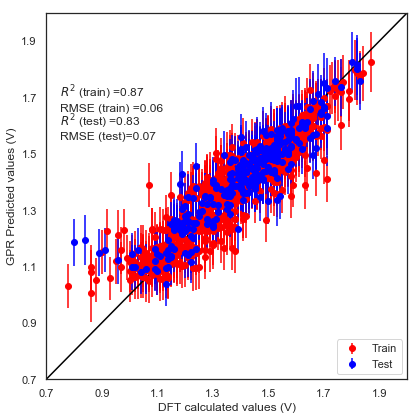

In [52]:
X=Xdata_btz_uncorr_clean
y=ERed_data["Ered(V)"]
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pytorch(X=X,y=y,train_pc=0.8)
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=False,data=False)

# PCA 

test data is not provided, returning only scaled train data
No. of PC           Cumulative variance                                                             
--------------------------------------------------
1                   0.249959                                                                        
2                   0.435858                                                                        
3                   0.530743                                                                        
4                   0.611534                                                                        
5                   0.682140                                                                        
6                   0.746214                                                                        
7                   0.792963                                                                        
8                   0.831795                                                     

C:\Users\jaina\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


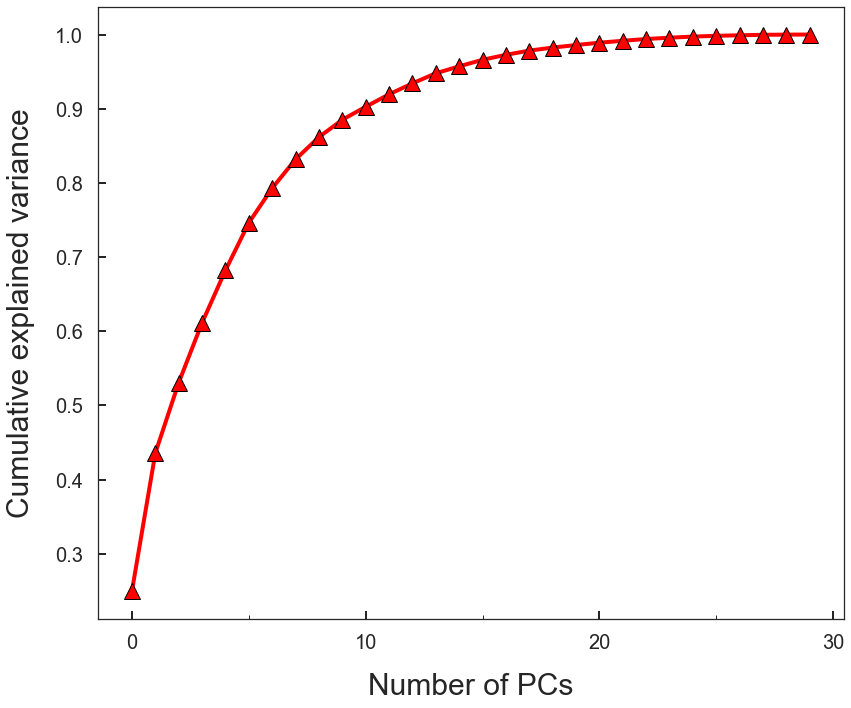

In [53]:
from sklearn.decomposition import PCA # Principle component analysis
import matplotlib.pyplot as plt  
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

X=Xdata_btz_uncorr_clean

X_st= do_scaling(scaler=StandardScaler(),xtrain=X, xtest=None)
pca = PCA().fit(X_st)

#Plotting
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of PCs', fontsize=30,labelpad=20)
ax1.set_ylabel('Cumulative explained variance', fontsize=30,labelpad=20)
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis='both', which='major', direction='in', size=8, left='on', bottom='on', width=2, pad=15)
ax1.tick_params(axis='both', which='minor', direction='in', size=4, left='on', bottom='on',width=1, pad=15)
ax1.tick_params(axis="y", labelsize=20)
ax1.tick_params(axis="x", labelsize=20)

plt.gcf().set_size_inches((12, 10))
evr = np.cumsum(pca.explained_variance_ratio_)
ax1.plot(evr, marker='^',markersize=16, markeredgecolor='black', 
         linestyle='-',linewidth=4, color='red')   # Plotting
plt.tight_layout()
# plt.savefig("./Figures/Xdata_reduced_pca.png",dpi=300)
print('{:<20s}{:<80s}'.format('No. of PC','Cumulative variance'))
print(50*'-')
for i,a in enumerate(evr):
    if a<=1:
        print('{:<20d}{:<80f}'.format(i+1,a))

# Features

In [54]:
from sklearn.model_selection import KFold

In [55]:
num_PCs = np.arange(1,31,4)
num_PCs

array([ 1,  5,  9, 13, 17, 21, 25, 29])

In [56]:
def gpr_one_pca_pytorch(X,y,train_by_test=0.8,nPC=5,random_state=None):

    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_by_test,random_state=random_state) 

    xtrain, xtest = do_scaling(scaler=RobustScaler(),xtrain=X_train, xtest=X_test)
    # PCA
    n_PC = nPC  # Set number of principle components
    pca = PCA(n_components=n_PC)
        
    xtrain = pca.fit_transform(xtrain) 
    xtest=pca.transform(xtest)
    print(f"xtrain.shape={xtrain.shape},xtest.shape={xtest.shape}")
    model, likelihood = gpregression_pytorch(xtrain,y_train,verbose=False)
    
    ypred_test, yerr_test = gprediction_pytorch(model,likelihood,xtest)
    ypred_train, yerr_train = gprediction_pytorch(model,likelihood,xtrain)
    
    return y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train

In [57]:
def helper(X,y,nPC=5,random_state=None):
    y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_by_test=0.8,nPC=nPC,random_state=random_state)
    r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train=plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=False,savefig=False,data=True)
    return r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train

In [58]:
train_score = np.zeros([len(num_PCs),3])
test_score = np.zeros([len(num_PCs),3])

In [59]:
for idx,PCs in enumerate(num_PCs):
    print(f"--> %idx/num_PCs={100*idx/len(num_PCs)}  <--")
    # split train and test datasets
    X=Xdata_btz_uncorr_clean
    y=ERed_data["Ered(V)"]
   
    test_score[idx][0],test_score[idx][1],test_score[idx][2],train_score[idx][0],train_score[idx][1],train_score[idx][2]=helper(X=X,y=y,nPC=PCs,random_state=8)

--> %idx/num_PCs=0.0  <--
returning scaled train and test data
xtrain.shape=(1224, 1),xtest.shape=(306, 1)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.40, RMSE = 0.13, MAE = 0.10)
(Test:  R2 = 0.32, RMSE = 0.14, MAE = 0.11)
--> %idx/num_PCs=12.5  <--
returning scaled train and test data
xtrain.shape=(1224, 5),xtest.shape=(306, 5)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.80, RMSE = 0.08, MAE = 0.06)
(Test:  R2 = 0.69, RMSE = 0.10, MAE = 0.07)
--> %idx/num_PCs=25.0  <--
returning scaled train and test data
xtrain.shape=(1224, 9),xtest.shape=(306, 9)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.85, RMSE = 0.07, MAE = 0.05)
(Test:  R2 = 0.76, RMSE = 0.08, MAE = 0.06)
--> %idx/num_PCs=37.5  <--
returning scaled train and test data
xtrain.shape=(1224, 13),xtest.shape=(306, 13)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.86, RMSE = 0.06, MAE = 0.05)
(Test:  R2 = 0.77, RMSE = 0.08, MAE = 0.06)
--> %idx/num_PCs=50.0  <--
returning scaled train and test data
xtrain.shape=(1224, 17),xtest.shape=(306, 17)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.05)
(Test:  R2 = 0.78, RMSE = 0.08, MAE = 0.06)
--> %idx/num_PCs=62.5  <--
returning scaled train and test data
xtrain.shape=(1224, 21),xtest.shape=(306, 21)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.78, RMSE = 0.08, MAE = 0.06)
--> %idx/num_PCs=75.0  <--
returning scaled train and test data
xtrain.shape=(1224, 25),xtest.shape=(306, 25)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.78, RMSE = 0.08, MAE = 0.06)
--> %idx/num_PCs=87.5  <--
returning scaled train and test data
xtrain.shape=(1224, 29),xtest.shape=(306, 29)
(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.78, RMSE = 0.08, MAE = 0.06)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


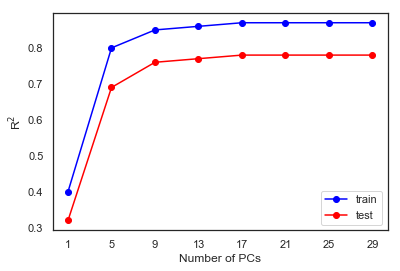

In [60]:
plt.plot(num_PCs,train_score[:,0],"-o",label="train",color="blue")
plt.plot(num_PCs,test_score[:,0],"-o",label="test",color="red")
plt.xlabel("Number of PCs")
plt.ylabel("R$^2$")
plt.legend()
plt.xticks(num_PCs)
plt.show()

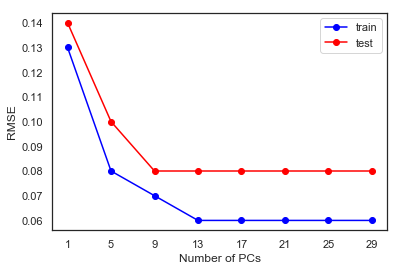

In [61]:
plt.plot(num_PCs,train_score[:,1],"-o",label="train",color="blue")
plt.plot(num_PCs,test_score[:,1],"-o",label="test",color="red")
plt.xlabel("Number of PCs")
plt.ylabel("RMSE")
plt.legend()
plt.xticks(num_PCs)
plt.show()

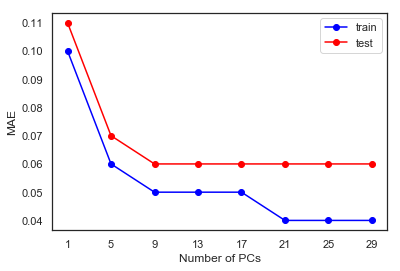

In [62]:
plt.plot(num_PCs,train_score[:,2],"-o",label="train",color="blue")
plt.plot(num_PCs,test_score[:,2],"-o",label="test",color="red")
plt.xlabel("Number of PCs")
plt.ylabel("MAE")
plt.legend()
plt.xticks(num_PCs)
plt.show()

Repeat 10 times

In [63]:
avg_train_score = np.zeros([len(num_PCs),3])
avg_test_score = np.zeros([len(num_PCs),3])

std_train_score = np.zeros([len(num_PCs),3])
std_test_score = np.zeros([len(num_PCs),3])

In [64]:
for idx,PCs in enumerate(num_PCs):
    print(f"--> %idx/num_PCs={100*idx/len(num_PCs)}  <--")
    # split train and test datasets
    X=Xdata_btz_uncorr_clean
    y=ERed_data["Ered(V)"]
    
    repeats=10
    r2_train,rmse_train,mae_train=np.zeros(repeats),np.zeros(repeats),np.zeros(repeats)
    r2_test,rmse_test,mae_test=np.zeros(repeats),np.zeros(repeats),np.zeros(repeats)

    for j in np.arange(repeats):
        print(f" ---> %repeat <-- ={100*j/repeats}")
        r2_test[j],rmse_test[j],mae_test[j],r2_train[j],rmse_train[j],mae_train[j]=helper(X=X,y=y,nPC=PCs)

    avg_test_score[idx] = r2_test.mean(),rmse_test.mean(),mae_test.mean()
    avg_train_score[idx] = r2_train.mean(),rmse_train.mean(),mae_train.mean()
    std_test_score[idx] = r2_test.std(),rmse_test.std(),mae_test.std()
    std_train_score[idx] = r2_train.std(),rmse_train.std(),mae_train.std()
    

--> %idx/num_PCs=0.0  <--
 ---> %repeat <-- =0.0
returning scaled train and test data
xtrain.shape=(1224, 1),xtest.shape=(306, 1)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.44, RMSE = 0.13, MAE = 0.10)
(Test:  R2 = 0.36, RMSE = 0.13, MAE = 0.10)
 ---> %repeat <-- =10.0
returning scaled train and test data
xtrain.shape=(1224, 1),xtest.shape=(306, 1)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.37, RMSE = 0.14, MAE = 0.10)
(Test:  R2 = 0.33, RMSE = 0.14, MAE = 0.11)
 ---> %repeat <-- =20.0
returning scaled train and test data
xtrain.shape=(1224, 1),xtest.shape=(306, 1)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.43, RMSE = 0.13, MAE = 0.10)
(Test:  R2 = 0.39, RMSE = 0.13, MAE = 0.10)
 ---> %repeat <-- =30.0
returning scaled train and test data
xtrain.shape=(1224, 1),xtest.shape=(306, 1)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.37, RMSE = 0.14, MAE = 0.11)
(Test:  R2 = 0.42, RMSE = 0.14, MAE = 0.10)
 ---> %repeat <-- =40.0
returning scaled train and test data
xtrain.shape=(1224, 1),xtest.shape=(306, 1)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.43, RMSE = 0.13, MAE = 0.10)
(Test:  R2 = 0.38, RMSE = 0.13, MAE = 0.10)
 ---> %repeat <-- =50.0
returning scaled train and test data
xtrain.shape=(1224, 1),xtest.shape=(306, 1)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.41, RMSE = 0.13, MAE = 0.10)
(Test:  R2 = 0.42, RMSE = 0.13, MAE = 0.10)
 ---> %repeat <-- =60.0
returning scaled train and test data
xtrain.shape=(1224, 1),xtest.shape=(306, 1)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.43, RMSE = 0.13, MAE = 0.10)
(Test:  R2 = 0.39, RMSE = 0.14, MAE = 0.11)
 ---> %repeat <-- =70.0
returning scaled train and test data
xtrain.shape=(1224, 1),xtest.shape=(306, 1)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.39, RMSE = 0.13, MAE = 0.10)
(Test:  R2 = 0.38, RMSE = 0.14, MAE = 0.11)
 ---> %repeat <-- =80.0
returning scaled train and test data
xtrain.shape=(1224, 1),xtest.shape=(306, 1)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.41, RMSE = 0.13, MAE = 0.10)
(Test:  R2 = 0.31, RMSE = 0.15, MAE = 0.11)
 ---> %repeat <-- =90.0
returning scaled train and test data
xtrain.shape=(1224, 1),xtest.shape=(306, 1)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.42, RMSE = 0.13, MAE = 0.10)
(Test:  R2 = 0.42, RMSE = 0.13, MAE = 0.10)
--> %idx/num_PCs=12.5  <--
 ---> %repeat <-- =0.0
returning scaled train and test data
xtrain.shape=(1224, 5),xtest.shape=(306, 5)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.78, RMSE = 0.08, MAE = 0.06)
(Test:  R2 = 0.77, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =10.0
returning scaled train and test data
xtrain.shape=(1224, 5),xtest.shape=(306, 5)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.79, RMSE = 0.08, MAE = 0.06)
(Test:  R2 = 0.72, RMSE = 0.09, MAE = 0.07)
 ---> %repeat <-- =20.0
returning scaled train and test data
xtrain.shape=(1224, 5),xtest.shape=(306, 5)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.79, RMSE = 0.08, MAE = 0.06)
(Test:  R2 = 0.75, RMSE = 0.09, MAE = 0.07)
 ---> %repeat <-- =30.0
returning scaled train and test data
xtrain.shape=(1224, 5),xtest.shape=(306, 5)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.79, RMSE = 0.08, MAE = 0.06)
(Test:  R2 = 0.72, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =40.0
returning scaled train and test data
xtrain.shape=(1224, 5),xtest.shape=(306, 5)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.78, RMSE = 0.08, MAE = 0.06)
(Test:  R2 = 0.76, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =50.0
returning scaled train and test data
xtrain.shape=(1224, 5),xtest.shape=(306, 5)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.79, RMSE = 0.08, MAE = 0.06)
(Test:  R2 = 0.71, RMSE = 0.09, MAE = 0.07)
 ---> %repeat <-- =60.0
returning scaled train and test data
xtrain.shape=(1224, 5),xtest.shape=(306, 5)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.78, RMSE = 0.08, MAE = 0.06)
(Test:  R2 = 0.74, RMSE = 0.09, MAE = 0.07)
 ---> %repeat <-- =70.0
returning scaled train and test data
xtrain.shape=(1224, 5),xtest.shape=(306, 5)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.80, RMSE = 0.08, MAE = 0.06)
(Test:  R2 = 0.69, RMSE = 0.10, MAE = 0.08)
 ---> %repeat <-- =80.0
returning scaled train and test data
xtrain.shape=(1224, 5),xtest.shape=(306, 5)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.81, RMSE = 0.08, MAE = 0.06)
(Test:  R2 = 0.68, RMSE = 0.09, MAE = 0.07)
 ---> %repeat <-- =90.0
returning scaled train and test data
xtrain.shape=(1224, 5),xtest.shape=(306, 5)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.79, RMSE = 0.08, MAE = 0.06)
(Test:  R2 = 0.74, RMSE = 0.09, MAE = 0.07)
--> %idx/num_PCs=25.0  <--
 ---> %repeat <-- =0.0
returning scaled train and test data
xtrain.shape=(1224, 9),xtest.shape=(306, 9)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.85, RMSE = 0.07, MAE = 0.05)
(Test:  R2 = 0.78, RMSE = 0.09, MAE = 0.06)
 ---> %repeat <-- =10.0
returning scaled train and test data
xtrain.shape=(1224, 9),xtest.shape=(306, 9)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.85, RMSE = 0.07, MAE = 0.05)
(Test:  R2 = 0.79, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =20.0
returning scaled train and test data
xtrain.shape=(1224, 9),xtest.shape=(306, 9)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.85, RMSE = 0.07, MAE = 0.05)
(Test:  R2 = 0.80, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =30.0
returning scaled train and test data
xtrain.shape=(1224, 9),xtest.shape=(306, 9)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.84, RMSE = 0.07, MAE = 0.05)
(Test:  R2 = 0.82, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =40.0
returning scaled train and test data
xtrain.shape=(1224, 9),xtest.shape=(306, 9)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.84, RMSE = 0.07, MAE = 0.05)
(Test:  R2 = 0.82, RMSE = 0.07, MAE = 0.06)
 ---> %repeat <-- =50.0
returning scaled train and test data
xtrain.shape=(1224, 9),xtest.shape=(306, 9)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.85, RMSE = 0.07, MAE = 0.05)
(Test:  R2 = 0.79, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =60.0
returning scaled train and test data
xtrain.shape=(1224, 9),xtest.shape=(306, 9)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.84, RMSE = 0.07, MAE = 0.05)
(Test:  R2 = 0.81, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =70.0
returning scaled train and test data
xtrain.shape=(1224, 9),xtest.shape=(306, 9)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.85, RMSE = 0.07, MAE = 0.05)
(Test:  R2 = 0.81, RMSE = 0.08, MAE = 0.05)
 ---> %repeat <-- =80.0
returning scaled train and test data
xtrain.shape=(1224, 9),xtest.shape=(306, 9)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.84, RMSE = 0.07, MAE = 0.05)
(Test:  R2 = 0.81, RMSE = 0.08, MAE = 0.05)
 ---> %repeat <-- =90.0
returning scaled train and test data
xtrain.shape=(1224, 9),xtest.shape=(306, 9)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.85, RMSE = 0.07, MAE = 0.05)
(Test:  R2 = 0.77, RMSE = 0.08, MAE = 0.06)
--> %idx/num_PCs=37.5  <--
 ---> %repeat <-- =0.0
returning scaled train and test data
xtrain.shape=(1224, 13),xtest.shape=(306, 13)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.86, RMSE = 0.06, MAE = 0.05)
(Test:  R2 = 0.81, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =10.0
returning scaled train and test data
xtrain.shape=(1224, 13),xtest.shape=(306, 13)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.86, RMSE = 0.06, MAE = 0.05)
(Test:  R2 = 0.82, RMSE = 0.07, MAE = 0.05)
 ---> %repeat <-- =20.0
returning scaled train and test data
xtrain.shape=(1224, 13),xtest.shape=(306, 13)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.86, RMSE = 0.06, MAE = 0.05)
(Test:  R2 = 0.81, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =30.0
returning scaled train and test data
xtrain.shape=(1224, 13),xtest.shape=(306, 13)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.78, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =40.0
returning scaled train and test data
xtrain.shape=(1224, 13),xtest.shape=(306, 13)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.05)
(Test:  R2 = 0.78, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =50.0
returning scaled train and test data
xtrain.shape=(1224, 13),xtest.shape=(306, 13)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.77, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =60.0
returning scaled train and test data
xtrain.shape=(1224, 13),xtest.shape=(306, 13)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.05)
(Test:  R2 = 0.78, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =70.0
returning scaled train and test data
xtrain.shape=(1224, 13),xtest.shape=(306, 13)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.86, RMSE = 0.06, MAE = 0.05)
(Test:  R2 = 0.81, RMSE = 0.07, MAE = 0.05)
 ---> %repeat <-- =80.0
returning scaled train and test data
xtrain.shape=(1224, 13),xtest.shape=(306, 13)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.85, RMSE = 0.06, MAE = 0.05)
(Test:  R2 = 0.83, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =90.0
returning scaled train and test data
xtrain.shape=(1224, 13),xtest.shape=(306, 13)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.05)
(Test:  R2 = 0.79, RMSE = 0.08, MAE = 0.06)
--> %idx/num_PCs=50.0  <--
 ---> %repeat <-- =0.0
returning scaled train and test data
xtrain.shape=(1224, 17),xtest.shape=(306, 17)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.80, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =10.0
returning scaled train and test data
xtrain.shape=(1224, 17),xtest.shape=(306, 17)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.77, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =20.0
returning scaled train and test data
xtrain.shape=(1224, 17),xtest.shape=(306, 17)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.05)
(Test:  R2 = 0.81, RMSE = 0.08, MAE = 0.05)
 ---> %repeat <-- =30.0
returning scaled train and test data
xtrain.shape=(1224, 17),xtest.shape=(306, 17)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.78, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =40.0
returning scaled train and test data
xtrain.shape=(1224, 17),xtest.shape=(306, 17)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.86, RMSE = 0.06, MAE = 0.05)
(Test:  R2 = 0.81, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =50.0
returning scaled train and test data
xtrain.shape=(1224, 17),xtest.shape=(306, 17)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.79, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =60.0
returning scaled train and test data
xtrain.shape=(1224, 17),xtest.shape=(306, 17)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.80, RMSE = 0.07, MAE = 0.05)
 ---> %repeat <-- =70.0
returning scaled train and test data
xtrain.shape=(1224, 17),xtest.shape=(306, 17)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.82, RMSE = 0.07, MAE = 0.06)
 ---> %repeat <-- =80.0
returning scaled train and test data
xtrain.shape=(1224, 17),xtest.shape=(306, 17)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.81, RMSE = 0.08, MAE = 0.05)
 ---> %repeat <-- =90.0
returning scaled train and test data
xtrain.shape=(1224, 17),xtest.shape=(306, 17)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.75, RMSE = 0.09, MAE = 0.06)
--> %idx/num_PCs=62.5  <--
 ---> %repeat <-- =0.0
returning scaled train and test data
xtrain.shape=(1224, 21),xtest.shape=(306, 21)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.80, RMSE = 0.09, MAE = 0.06)
 ---> %repeat <-- =10.0
returning scaled train and test data
xtrain.shape=(1224, 21),xtest.shape=(306, 21)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.81, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =20.0
returning scaled train and test data
xtrain.shape=(1224, 21),xtest.shape=(306, 21)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.79, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =30.0
returning scaled train and test data
xtrain.shape=(1224, 21),xtest.shape=(306, 21)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.77, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =40.0
returning scaled train and test data
xtrain.shape=(1224, 21),xtest.shape=(306, 21)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.89, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.76, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =50.0
returning scaled train and test data
xtrain.shape=(1224, 21),xtest.shape=(306, 21)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.78, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =60.0
returning scaled train and test data
xtrain.shape=(1224, 21),xtest.shape=(306, 21)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.81, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =70.0
returning scaled train and test data
xtrain.shape=(1224, 21),xtest.shape=(306, 21)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.78, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =80.0
returning scaled train and test data
xtrain.shape=(1224, 21),xtest.shape=(306, 21)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.80, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =90.0
returning scaled train and test data
xtrain.shape=(1224, 21),xtest.shape=(306, 21)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.89, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.71, RMSE = 0.09, MAE = 0.06)
--> %idx/num_PCs=75.0  <--
 ---> %repeat <-- =0.0
returning scaled train and test data
xtrain.shape=(1224, 25),xtest.shape=(306, 25)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.81, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =10.0
returning scaled train and test data
xtrain.shape=(1224, 25),xtest.shape=(306, 25)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.78, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =20.0
returning scaled train and test data
xtrain.shape=(1224, 25),xtest.shape=(306, 25)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.81, RMSE = 0.08, MAE = 0.05)
 ---> %repeat <-- =30.0
returning scaled train and test data
xtrain.shape=(1224, 25),xtest.shape=(306, 25)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.78, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =40.0
returning scaled train and test data
xtrain.shape=(1224, 25),xtest.shape=(306, 25)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.79, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =50.0
returning scaled train and test data
xtrain.shape=(1224, 25),xtest.shape=(306, 25)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.81, RMSE = 0.08, MAE = 0.05)
 ---> %repeat <-- =60.0
returning scaled train and test data
xtrain.shape=(1224, 25),xtest.shape=(306, 25)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.84, RMSE = 0.07, MAE = 0.05)
 ---> %repeat <-- =70.0
returning scaled train and test data
xtrain.shape=(1224, 25),xtest.shape=(306, 25)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.81, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =80.0
returning scaled train and test data
xtrain.shape=(1224, 25),xtest.shape=(306, 25)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.80, RMSE = 0.07, MAE = 0.05)
 ---> %repeat <-- =90.0
returning scaled train and test data
xtrain.shape=(1224, 25),xtest.shape=(306, 25)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.81, RMSE = 0.07, MAE = 0.05)
--> %idx/num_PCs=87.5  <--
 ---> %repeat <-- =0.0
returning scaled train and test data
xtrain.shape=(1224, 29),xtest.shape=(306, 29)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.77, RMSE = 0.09, MAE = 0.06)
 ---> %repeat <-- =10.0
returning scaled train and test data
xtrain.shape=(1224, 29),xtest.shape=(306, 29)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.89, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.76, RMSE = 0.09, MAE = 0.06)
 ---> %repeat <-- =20.0
returning scaled train and test data
xtrain.shape=(1224, 29),xtest.shape=(306, 29)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.80, RMSE = 0.08, MAE = 0.05)
 ---> %repeat <-- =30.0
returning scaled train and test data
xtrain.shape=(1224, 29),xtest.shape=(306, 29)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.78, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =40.0
returning scaled train and test data
xtrain.shape=(1224, 29),xtest.shape=(306, 29)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.81, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =50.0
returning scaled train and test data
xtrain.shape=(1224, 29),xtest.shape=(306, 29)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.80, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =60.0
returning scaled train and test data
xtrain.shape=(1224, 29),xtest.shape=(306, 29)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.86, RMSE = 0.07, MAE = 0.05)
 ---> %repeat <-- =70.0
returning scaled train and test data
xtrain.shape=(1224, 29),xtest.shape=(306, 29)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.89, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.80, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =80.0
returning scaled train and test data
xtrain.shape=(1224, 29),xtest.shape=(306, 29)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.80, RMSE = 0.08, MAE = 0.06)
 ---> %repeat <-- =90.0
returning scaled train and test data
xtrain.shape=(1224, 29),xtest.shape=(306, 29)
(Train: R2 = 0.89, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.77, RMSE = 0.08, MAE = 0.06)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


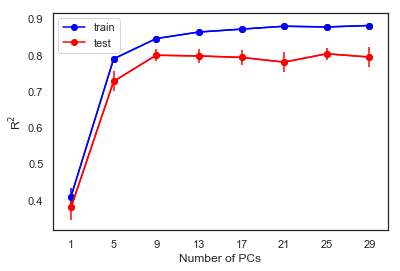

In [65]:
plt.plot(num_PCs,avg_train_score[:,0],"-o",label="train",color="blue")
plt.plot(num_PCs,avg_test_score[:,0],"-o",label="test",color="red")

plt.scatter(num_PCs,avg_train_score[:,0],color="blue")
plt.scatter(num_PCs,avg_test_score[:,0],color="red")

plt.errorbar(num_PCs,avg_train_score[:,0],yerr=std_train_score[:,0],color="blue")
plt.errorbar(num_PCs,avg_test_score[:,0],yerr=std_test_score[:,0],color="red")

plt.xlabel("Number of PCs")
plt.ylabel("R$^2$")
plt.legend()
plt.xticks(num_PCs)
plt.show()

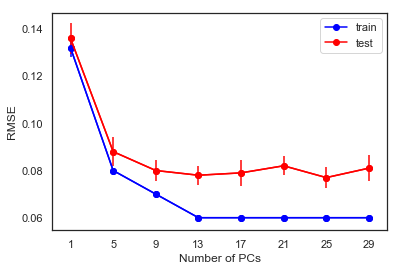

In [66]:
plt.plot(num_PCs,avg_train_score[:,1],"-o",label="train",color="blue")
plt.plot(num_PCs,avg_test_score[:,1],"-o",label="test",color="red")

plt.scatter(num_PCs,avg_train_score[:,1],color="blue")
plt.scatter(num_PCs,avg_test_score[:,1],color="red")

plt.errorbar(num_PCs,avg_train_score[:,1],yerr=std_train_score[:,1],color="blue")
plt.errorbar(num_PCs,avg_test_score[:,1],yerr=std_test_score[:,1],color="red")

plt.xlabel("Number of PCs")
plt.ylabel("RMSE")
plt.legend()
plt.xticks(num_PCs)
plt.show()

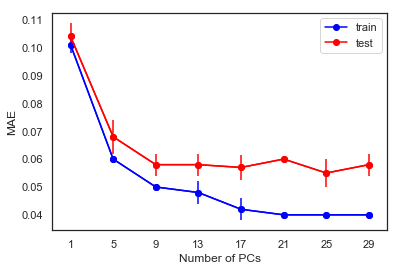

In [67]:
plt.plot(num_PCs,avg_train_score[:,2],"-o",label="train",color="blue")
plt.plot(num_PCs,avg_test_score[:,2],"-o",label="test",color="red")

plt.scatter(num_PCs,avg_train_score[:,2],color="blue")
plt.scatter(num_PCs,avg_test_score[:,2],color="red")

plt.errorbar(num_PCs,avg_train_score[:,2],yerr=std_train_score[:,2],color="blue")
plt.errorbar(num_PCs,avg_test_score[:,2],yerr=std_test_score[:,2],color="red")

plt.xlabel("Number of PCs")
plt.ylabel("MAE")
plt.legend()
plt.xticks(num_PCs)
plt.show()

# Use 21 PCs

returning scaled train and test data
xtrain.shape=(1224, 21),xtest.shape=(306, 21)
(Train: R2 = 0.88, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.76, RMSE = 0.08, MAE = 0.06)
Train: min error = 0.07 max_err 0.12
Test: min error = 0.07 max_err 0.12


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


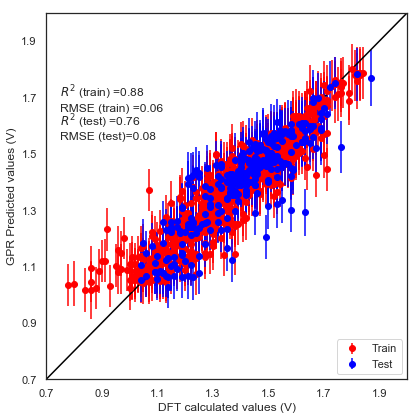

In [68]:
X=Xdata_btz_uncorr_clean
y=ERed_data["Ered(V)"]
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_by_test=0.8,nPC=21)
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=False,data=False)

returning scaled train and test data
xtrain.shape=(1224, 25),xtest.shape=(306, 25)


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.81, RMSE = 0.08, MAE = 0.06)
Train: min error = 0.07 max_err 0.11
Test: min error = 0.07 max_err 0.12


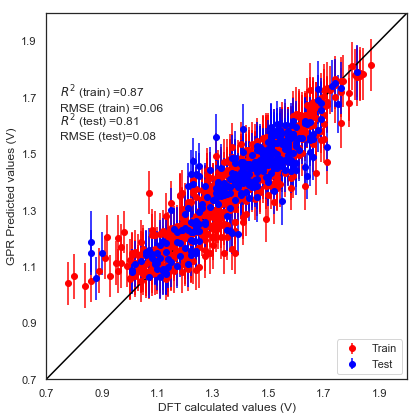

In [78]:
X=Xdata_btz_uncorr_clean
y=ERed_data["Ered(V)"]
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_by_test=0.8,nPC=25)
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=False,data=False)

In [69]:
# Suppress FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

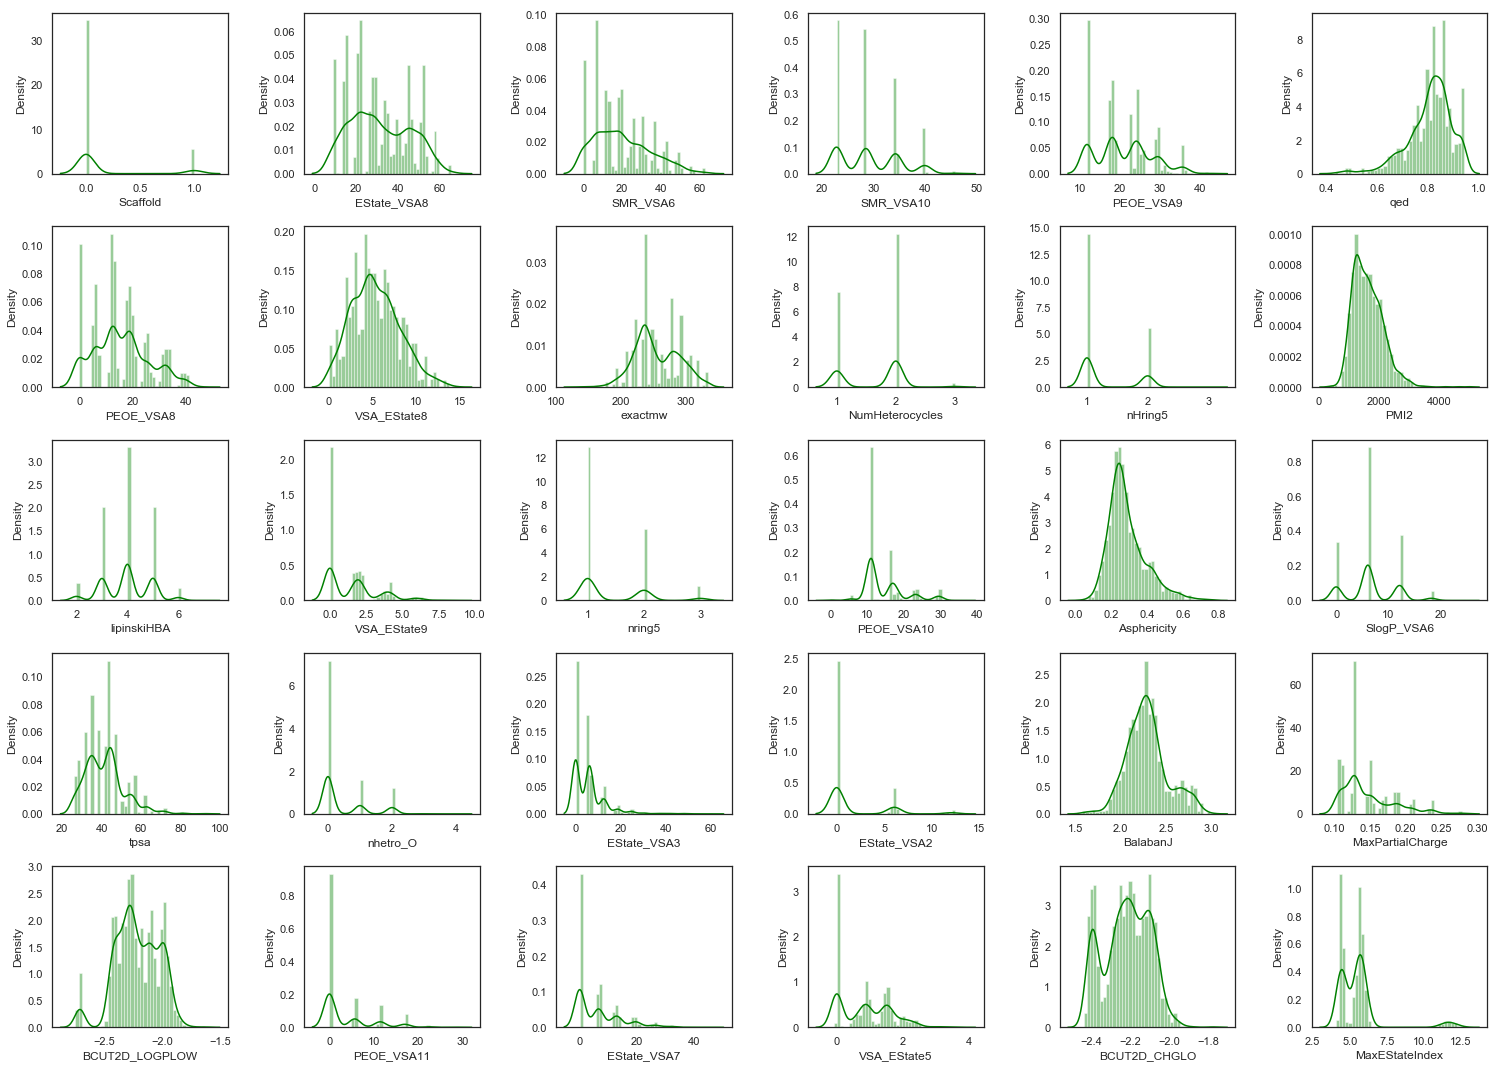

In [70]:
target = 'Ered(V)'
descriptors=X.columns.to_list()
from scipy.stats import norm
nr_rows = 5
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(descriptors):

            sns.distplot(x=X[descriptors[i]],color="green", ax = axs[r][c],bins=40,kde=True)

            axs[r][c].set_xlabel(descriptors[i])
        else:
            fig.delaxes(axs[r][c])
            
plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

# Transform features to log scale

In [71]:
df=np.log2(X)
df.replace([np.inf,-np.inf],np.nan,inplace=True)

In [72]:
df=df.dropna(axis=1)

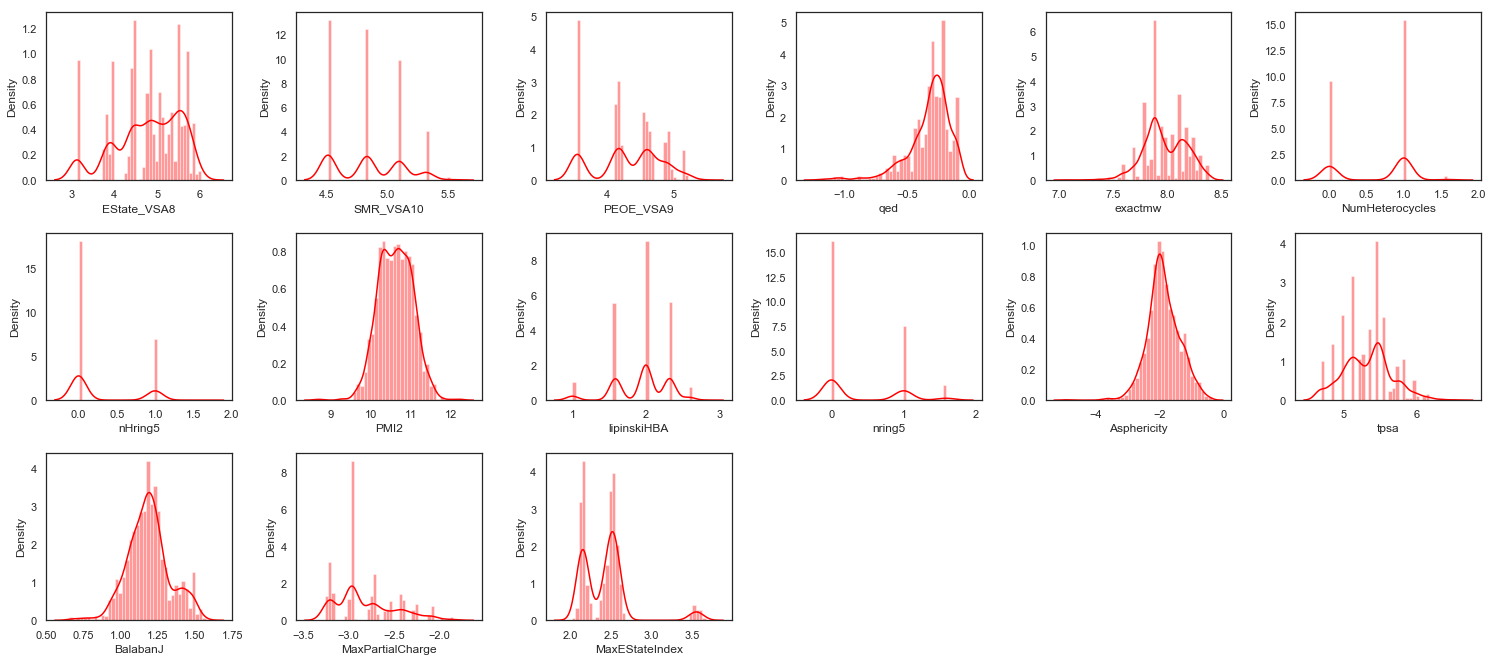

In [73]:
target = 'Ered(V)'
descriptors=df.columns.to_list()
from scipy.stats import norm
nr_rows = 5
nr_cols = 6
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(descriptors):

            # sns.distplot(x=X[descriptors[i]],color="green", ax = axs[r][c],bins=40,kde=True)
            sns.distplot(x=df[descriptors[i]],color="red", ax = axs[r][c],bins=40,kde=True)
            axs[r][c].set_xlabel(descriptors[i])
        else:
            fig.delaxes(axs[r][c])
            
plt.tight_layout()    
# plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

# Test performance of the GPR model with log(features)

In [74]:
df.shape,X.shape

((1530, 15), (1530, 30))

In [75]:
Xlog=pd.concat([df,X.drop(columns=df.columns)],axis=1)
Xlog

,EState_VSA8,SMR_VSA10,PEOE_VSA9,qed,exactmw,NumHeterocycles,nHring5,PMI2,lipinskiHBA,nring5,...,PEOE_VSA10,SlogP_VSA6,nhetro_O,EState_VSA3,EState_VSA2,BCUT2D_LOGPLOW,PEOE_VSA11,EState_VSA7,VSA_EState5,BCUT2D_CHGLO
0,5.847494,5.093237,4.530006,-0.214620,8.185628,1.0,0.0,11.356820,2.321928,0.0,...,11.033401,6.066367,0,0.000000,0.000000,-2.421053,0.000000,0.000000,0.000000,-2.382209
1,5.265315,5.093237,4.892869,-0.209834,8.190495,1.0,0.0,11.176054,2.321928,0.0,...,11.033401,6.066367,0,0.000000,0.000000,-2.423841,0.000000,0.000000,0.000000,-2.390295
2,5.851723,5.315557,4.847513,-0.086498,8.185628,1.0,0.0,10.826685,2.321928,0.0,...,11.033401,6.066367,0,6.041841,0.000000,-2.428193,0.000000,0.000000,0.000000,-2.402864
3,5.663950,5.315557,4.847513,-0.122018,8.253457,1.0,0.0,10.908500,2.321928,0.0,...,11.033401,6.066367,0,0.000000,0.000000,-2.414287,0.000000,0.000000,0.000000,-2.393344
4,5.848623,5.315557,4.847513,-0.089801,8.253457,1.0,0.0,10.885480,2.321928,0.0,...,11.033401,6.066367,0,6.041841,0.000000,-2.441912,0.000000,0.000000,0.000000,-2.414260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1525,4.442093,4.508529,3.551908,-0.317272,8.088177,0.0,0.0,10.657090,1.000000,0.0,...,11.033401,6.066367,0,0.000000,0.000000,-2.230510,0.000000,0.000000,1.629104,-2.392900
1526,4.368993,5.102100,3.551908,-0.552307,7.864572,1.0,0.0,10.592406,2.000000,0.0,...,11.414446,12.132734,0,12.338728,5.897745,-2.700819,5.516701,12.132734,0.455597,-2.066937
1527,3.128801,4.508529,4.235573,-0.629580,7.375214,0.0,0.0,9.700370,1.584963,0.0,...,16.782913,18.199101,0,0.000000,0.000000,-1.804742,0.000000,18.199101,0.824259,-1.952338
1528,3.128801,4.508529,3.551908,-0.861372,7.087564,0.0,0.0,8.631425,1.000000,0.0,...,11.033401,24.265468,0,0.000000,0.000000,-1.631595,0.000000,24.265468,0.000000,-1.781954


In [76]:
Xlog.isnull().sum(axis=0).sum(), Xlog.isna().sum(axis=0).sum()

(0, 0)

returning scaled train and test data
xtrain.shape=(1224, 21),xtest.shape=(306, 21)
(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.05)
(Test:  R2 = 0.80, RMSE = 0.07, MAE = 0.05)
Train: min error = 0.07 max_err 0.11
Test: min error = 0.07 max_err 0.11


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


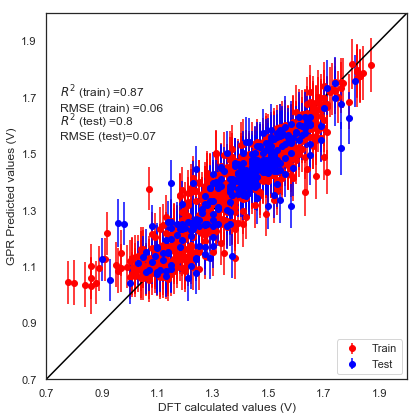

In [77]:
X = Xlog
y = ERed_data['Ered(V)']
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_by_test=0.8,nPC=21)
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=False,data=False)

returning scaled train and test data
xtrain.shape=(1224, 25),xtest.shape=(306, 25)
(Train: R2 = 0.87, RMSE = 0.06, MAE = 0.04)
(Test:  R2 = 0.84, RMSE = 0.07, MAE = 0.05)
Train: min error = 0.07 max_err 0.11
Test: min error = 0.07 max_err 0.12


c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


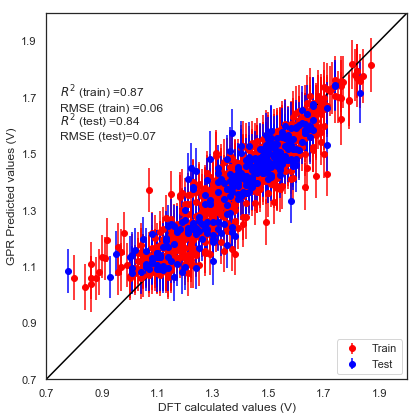

In [79]:
X = Xlog
y = ERed_data['Ered(V)']
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_by_test=0.8,nPC=25)
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=False,data=False)

**No improvement in the R2, RMSE and MAE after the log transformation**